In [1]:
# Import necessary libraries
import time
from math import sqrt
import os
import joblib

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from IPython.display import display

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression, Ridge, RidgeCV, SGDRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import Binarizer, MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

sns.set(font='serif', style='ticks')
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.sans-serif']=['Arial Unicode MS']

plt.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_columns',None)

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam, Adamax, Nadam
from tensorflow.keras.regularizers import l2

In [2]:
# Load data
data = pd.read_csv('./NbTi.csv')
X = data[['PSI', 'DELTA']]
Y = data[['n', 'k']]

In [3]:
# Standardize the data.
transfer1 = StandardScaler()
X = transfer1.fit_transform(X)

transfer2 = StandardScaler()
Y = transfer2.fit_transform(Y)

In [4]:
# Data is taken every 701 wavelengths
samples_per_slice = 701
n_samples = X.shape[0] // samples_per_slice
feature_slices_X = X[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
x = np.stack(feature_slices_X, axis=0)
samples_per_slice = 701
n_samples = Y.shape[0] // samples_per_slice
feature_slices_Y = Y[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
y = np.stack(feature_slices_Y, axis=0)

(271, 701, 2)


In [6]:
# Split the data into training and testing sets.
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.2, random_state=24,shuffle=True)

In [ ]:
# Parameter optimization
def create_model(trial):
    # Network structure parameter
    n_layers = trial.suggest_int("n_layers", 2, 6)
    filters = [trial.suggest_categorical(f"filters_{i}", [2, 4, 8, 16, 32, 64, 128, 256]) for i in range(n_layers)]
    kernel_size = trial.suggest_categorical("kernel_size", [2, 3, 4, 5])
    activation = trial.suggest_categorical("activation", ['relu', 'tanh', 'elu', 'leaky_relu'])  

    # Regularization parameter
    l2_strength = trial.suggest_float('l2_strength', 1e-100,1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)

    # Optimizer and learning rate
    optimizer_options = ['Adam', 'Nadam', 'Adamax']  # 移除Momentum和NAG
    optimizer_choice = trial.suggest_categorical("optimizer", optimizer_options)
    learning_rate = trial.suggest_float("learning_rate", 1e-10, 1e-1, log=True)

    
    if optimizer_choice == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'Nadam':
        optimizer = Nadam(learning_rate=learning_rate)
    elif optimizer_choice == 'Adamax':
        optimizer = Adamax(learning_rate=learning_rate)

    kernel_regularizer = l2(l2_strength)
    model = Sequential()

    # Add the Conv1D layer
    for i in range(n_layers):
        if i == 0:
            model.add(Conv1D(filters=filters[i], kernel_size=kernel_size, activation=activation, input_shape=(701, 2), kernel_regularizer=kernel_regularizer))
        else:
            model.add(Conv1D(filters=filters[i], kernel_size=kernel_size, activation=activation, kernel_regularizer=kernel_regularizer))
        model.add(MaxPooling1D(pool_size=2))
        
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(701 * 2))
    model.add(Reshape((701, 2)))

    # Compilation model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

def objective(trial):
    # Create models
    model = create_model(trial)

    # Training parameter
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128, 256, 512])
    
    # Data partitioning
    validation_split = trial.suggest_float("validation_split", 0.1, 0.7)
                                           
    # EarlyStopping parameter
    patience = trial.suggest_int("patience", 5, 70)
    callbacks = [EarlyStopping(monitor='val_loss', patience=patience, min_delta=0.00001)]

    # Training model
    history = model.fit(x_train, y_train, callbacks=callbacks, epochs=300, batch_size=batch_size, validation_split=validation_split)

    # Select the best epoch
    val_loss = np.min(history.history['val_loss'])

    # Clear the current TensorFlow diagram
    tf.keras.backend.clear_session()

    return val_loss

# Create a study object
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)  # 根据需要设置尝试次数

# Print optimum parameter
print(study.best_params)

In [ ]:
print("Best params:", study.best_params)
print("Best value:", study.best_value)

# Prints all parameters and values
print("All params and values:")
for trial in study.trials:
    print("Trial #{}: params={}, value={}".format(trial.number, trial.params, trial.value))

In [261]:
# Build the model according to the best parameters
l2_reg = l2(5.304250726644095e-10)

model = Sequential()

model.add(Conv1D(filters=256, kernel_size=2, activation='leaky_relu', input_shape=(701, 2), kernel_regularizer=l2_reg))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=2, activation='leaky_relu', kernel_regularizer=l2_reg))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=2, activation='leaky_relu', kernel_regularizer=l2_reg))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=2, activation='leaky_relu', kernel_regularizer=l2_reg))
model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.13793070702705323))
model.add(Flatten())
model.add(Dense(701 * 2))
model.add(Reshape((701, 2)))

# Output model structure
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_43 (Conv1D)          (None, 700, 256)          1280      
                                                                 
 max_pooling1d_43 (MaxPooli  (None, 350, 256)          0         
 ng1D)                                                           
                                                                 
 conv1d_44 (Conv1D)          (None, 349, 256)          131328    
                                                                 
 max_pooling1d_44 (MaxPooli  (None, 174, 256)          0         
 ng1D)                                                           
                                                                 
 conv1d_45 (Conv1D)          (None, 173, 32)           16416     
                                                                 
 max_pooling1d_45 (MaxPooli  (None, 86, 32)          

In [262]:
# Define early stopping callback.
callbacks = [EarlyStopping(monitor='val_loss', patience=57, verbose=1, min_delta=0.00001)]

In [263]:
# Compilation model
model.compile(loss='mean_squared_error', optimizer=Adamax(learning_rate=0.007759747196506469))

# Training model
history = model.fit(x_train, y_train, callbacks=callbacks,epochs=1000, batch_size=16, validation_split=0.4405220845038681)

Epoch 1/1000
8/8 [==============================] - 3s 280ms/step - loss: 1.5149 - val_loss: 0.2576
Epoch 2/1000
8/8 [==============================] - 2s 255ms/step - loss: 0.1490 - val_loss: 0.0908
Epoch 3/1000
8/8 [==============================] - 2s 251ms/step - loss: 0.0924 - val_loss: 0.0903
Epoch 4/1000
8/8 [==============================] - 2s 290ms/step - loss: 0.0783 - val_loss: 0.0667
Epoch 5/1000
8/8 [==============================] - 3s 326ms/step - loss: 0.0646 - val_loss: 0.0550
Epoch 6/1000
8/8 [==============================] - 2s 303ms/step - loss: 0.0580 - val_loss: 0.0558
Epoch 7/1000
8/8 [==============================] - 2s 308ms/step - loss: 0.0581 - val_loss: 0.0495
Epoch 8/1000
8/8 [==============================] - 3s 331ms/step - loss: 0.0529 - val_loss: 0.0484
Epoch 9/1000
8/8 [==============================] - 3s 326ms/step - loss: 0.0508 - val_loss: 0.0461
Epoch 10/1000
8/8 [==============================] - 3s 422ms/step - loss: 0.0492 - val_loss: 0.0463

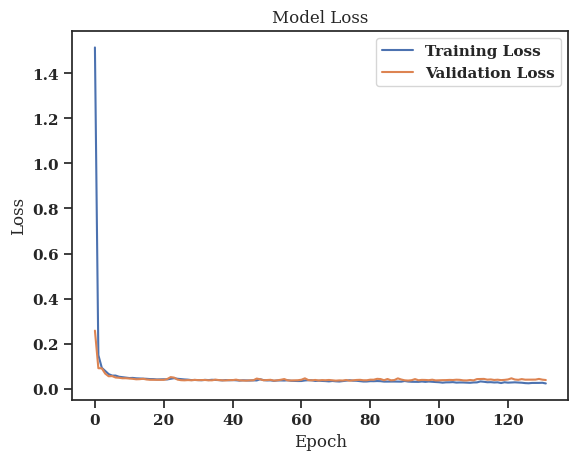

In [264]:
# Plot loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [12]:
# Predictive test set
y_pred = model.predict(x_test)
# Adjust back to two column shapes
y_pred_reshaped = y_pred.reshape(-1, 2)
print(y_pred_reshaped.shape)
y_test_reshaped = y_test.reshape(-1, 2)
print(y_test_reshaped.shape)

2/2 [==============================] - 0s 42ms/step
(38555, 2)
(38555, 2)


In [13]:
# Restore the normalized output to the original value
y_pred_reshaped = transfer2.inverse_transform(y_pred_reshaped)
y_test_reshaped = transfer2.inverse_transform(y_test_reshaped)

In [14]:
# Extract the first and second columns
n_pred = y_pred_reshaped[:, 0]
n_test = y_test_reshaped[:, 0]
k_pred = y_pred_reshaped[:, 1]
k_test = y_test_reshaped[:, 1]

print(n_pred.shape)  
print(n_test.shape)  
print(k_pred.shape)  
print(k_test.shape)  

(38555,)
(38555,)
(38555,)
(38555,)


In [16]:
# Calculate the loss of n
mse = mean_squared_error(n_test, n_pred)
print("n_test MSE: ", mse)
rmse = np.sqrt(mse)
print("n_test RMSE: ", rmse)
mae = mean_absolute_error(n_test, n_pred)
print("n_test MAE: ", mae)
r2 = r2_score(n_test, n_pred)
print("n_test R2 score: ", r2)

n_test MSE:  0.011217600157408676
n_test RMSE:  0.10591317272846035
n_test MAE:  0.07755628974492455
n_test R2 score:  0.8591205094014213


In [17]:
# Calculate the loss of k
mse = mean_squared_error(k_test, k_pred)
print("k_test MSE: ", mse)
rmse = np.sqrt(mse)
print("k_test RMSE: ", rmse)
mae = mean_absolute_error(k_test, k_pred)
print("k_test MAE: ", mae)
r2 = r2_score(k_test, k_pred)
print("k_test R2 score: ", r2)

k_test MSE:  0.0019067446907088616
k_test RMSE:  0.04366628780545538
k_test MAE:  0.02346682393295987
k_test R2 score:  0.9898421780925171


In [18]:
# Data is taken every 701 wavelengths
samples_per_slice = 701
n_samples = n_pred.shape[0] // samples_per_slice
feature_slices_pred = n_pred[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
n_pred = np.stack(feature_slices_pred, axis=0)
print(n_pred.shape) 

samples_per_slice = 701
n_samples = n_test.shape[0] // samples_per_slice
feature_slices_test = n_test[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
n_test = np.stack(feature_slices_test, axis=0)
print(n_test.shape)

samples_per_slice = 701
n_samples = k_pred.shape[0] // samples_per_slice
feature_slices_pred = k_pred[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
k_pred = np.stack(feature_slices_pred, axis=0)
print(k_pred.shape) 

samples_per_slice = 701
n_samples = k_test.shape[0] // samples_per_slice
feature_slices_test = k_test[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 1))
k_test = np.stack(feature_slices_test, axis=0)
print(k_test.shape)

(55, 701, 1)
(55, 701, 1)
(55, 701, 1)
(55, 701, 1)


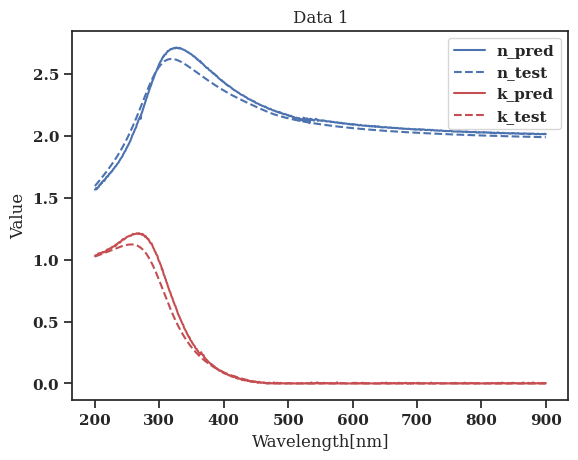

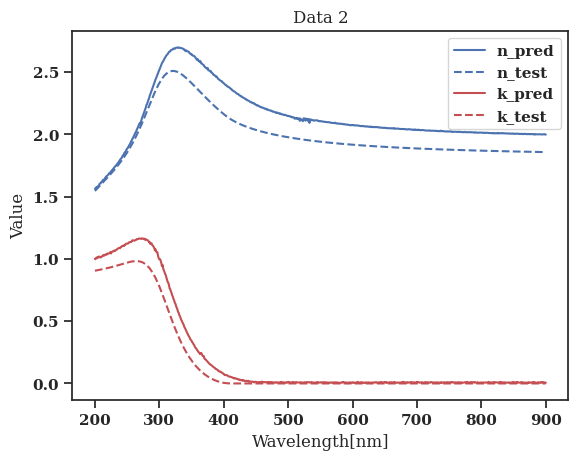

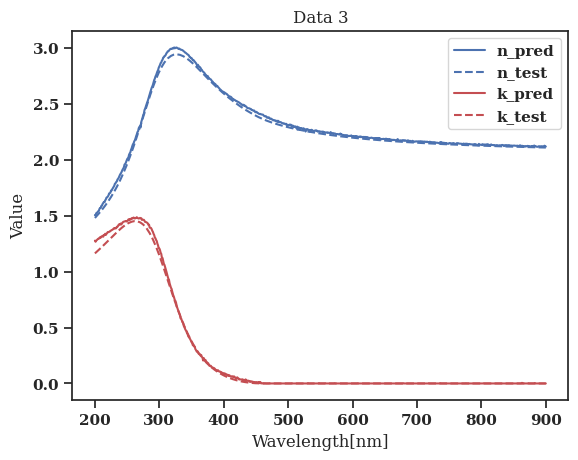

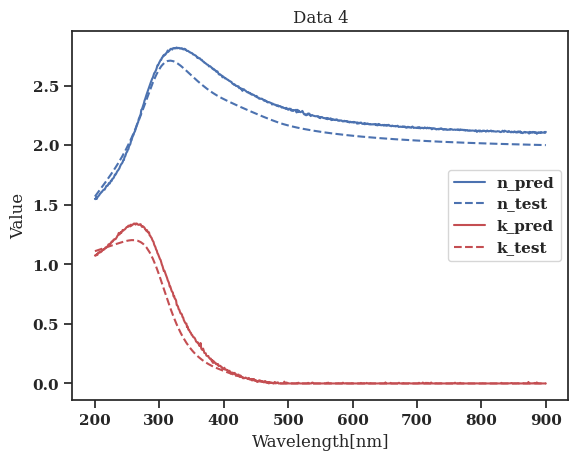

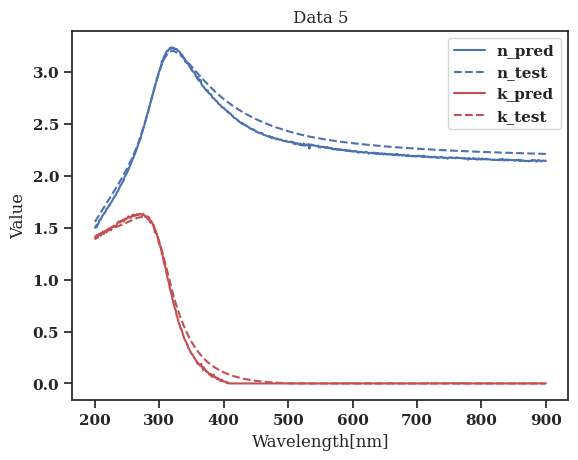

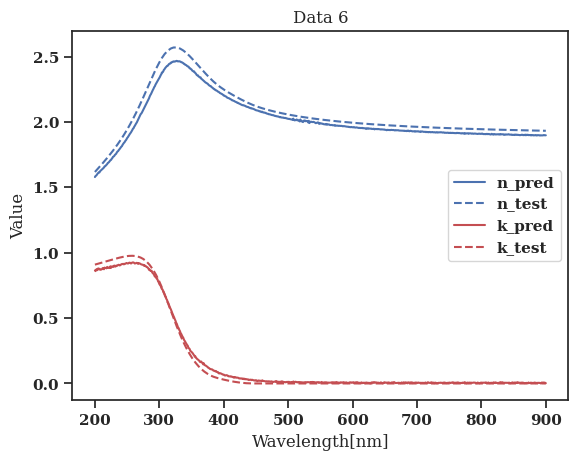

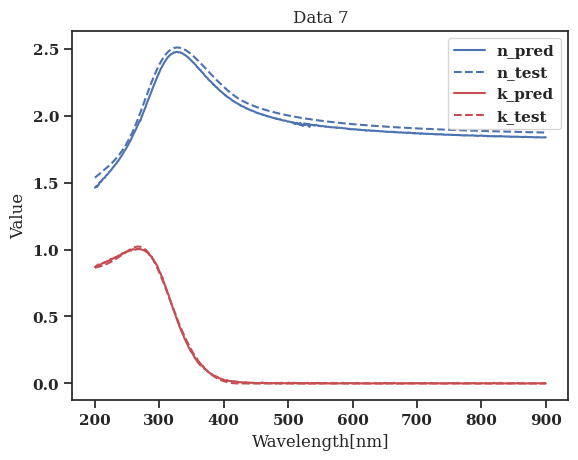

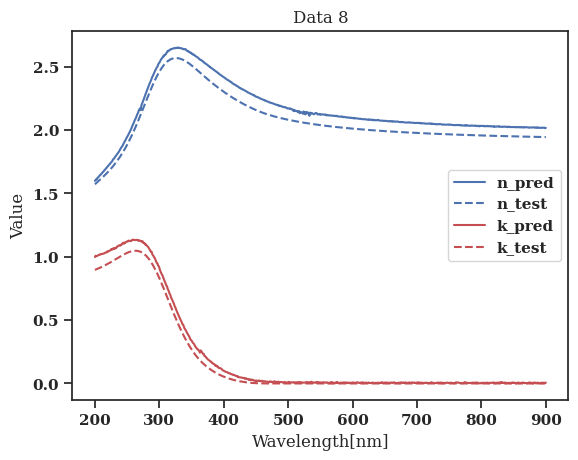

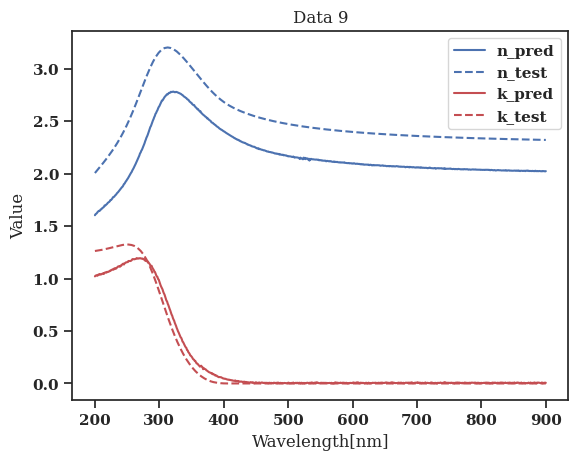

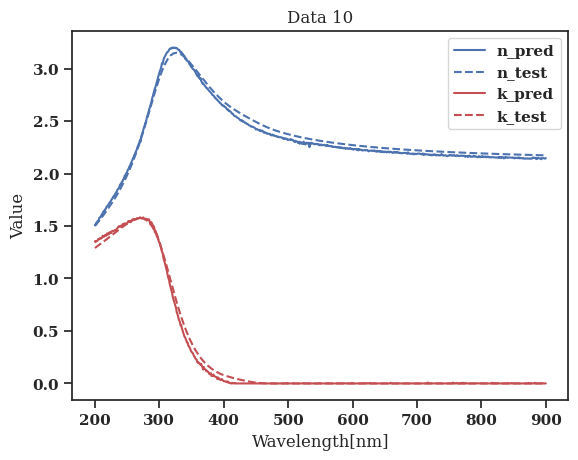

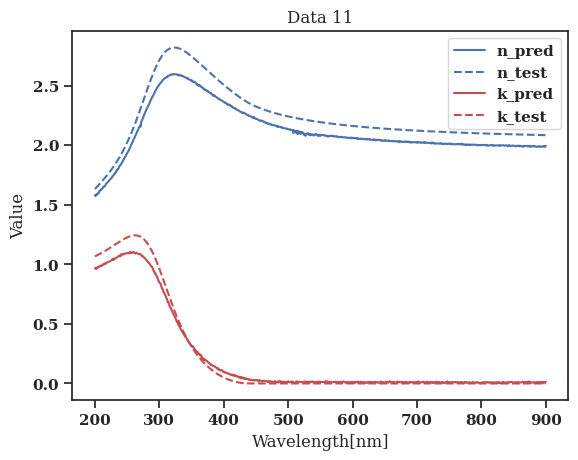

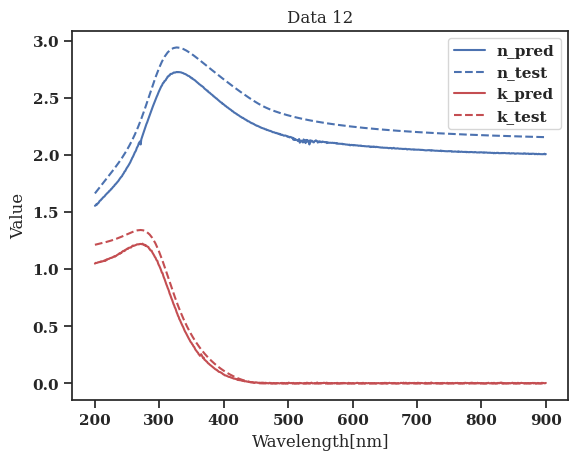

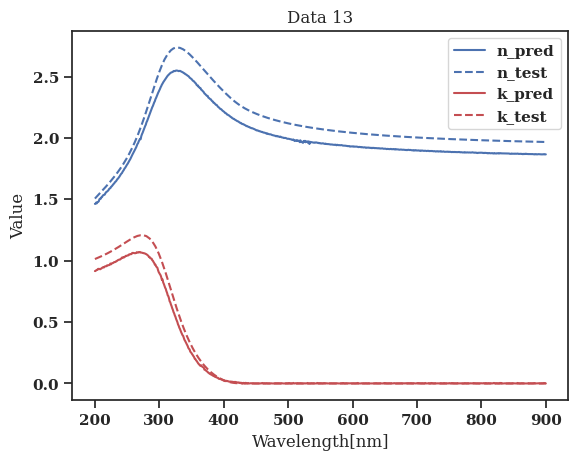

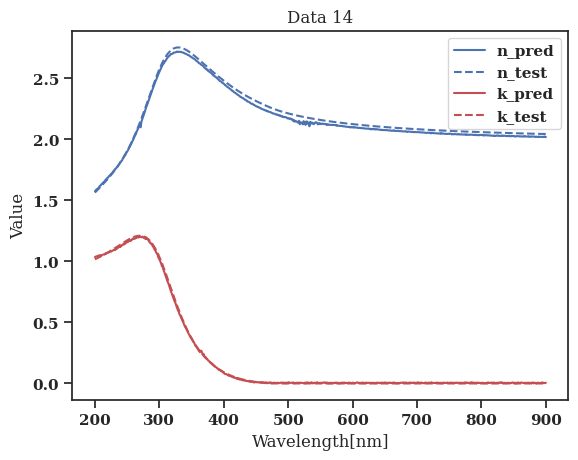

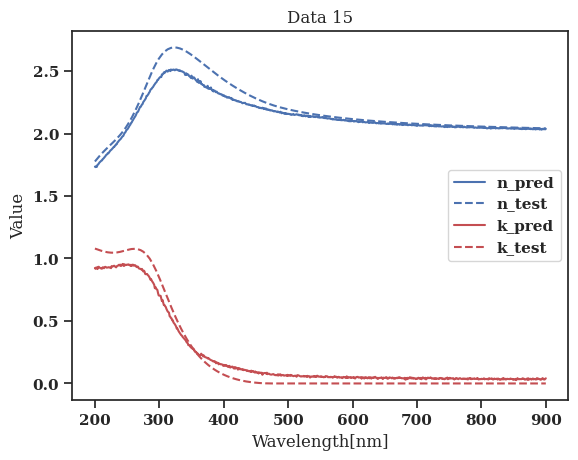

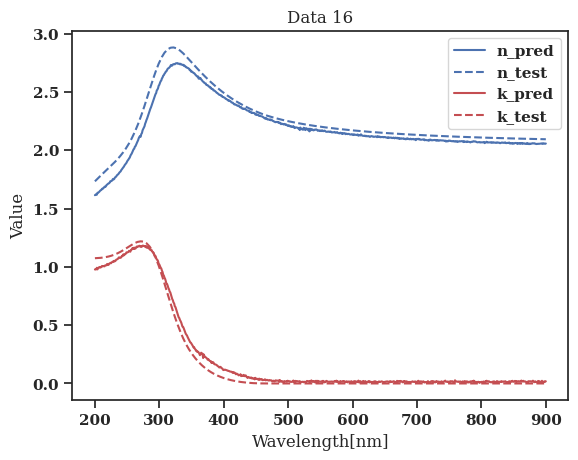

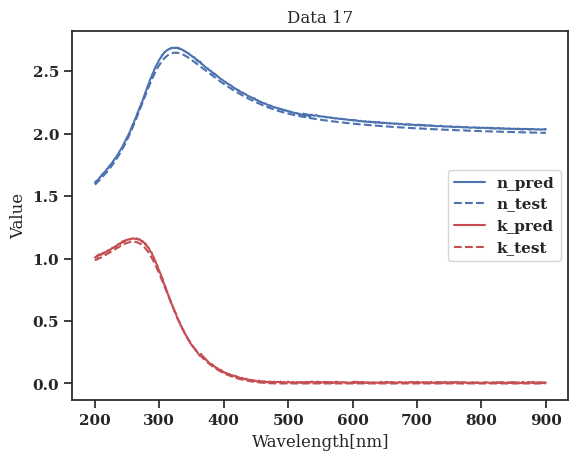

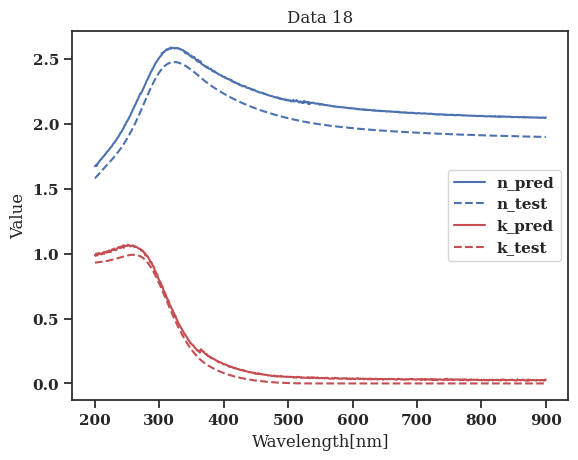

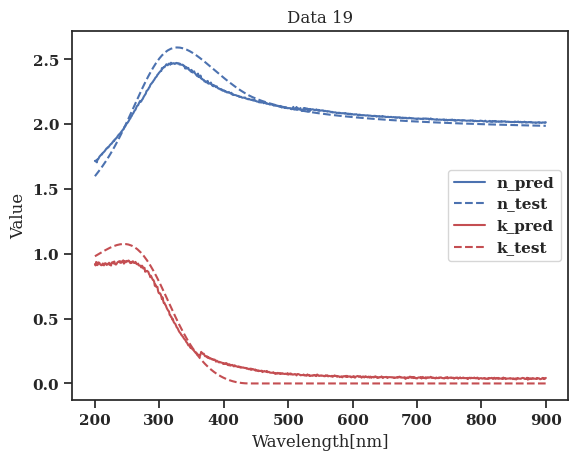

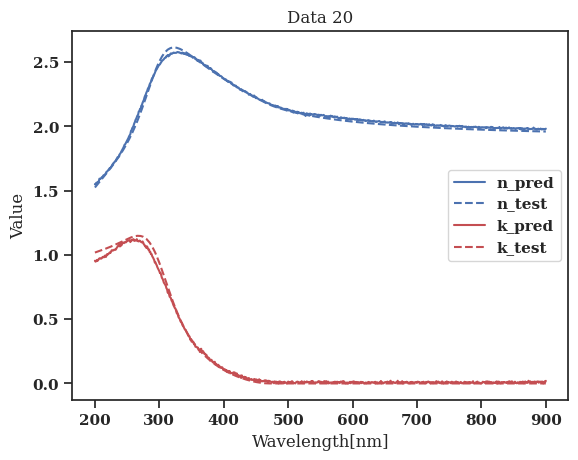

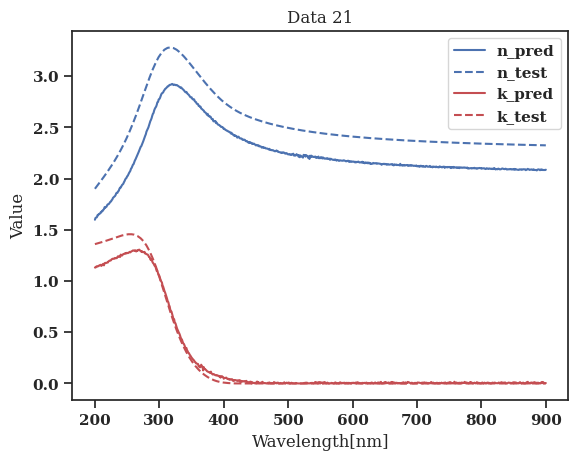

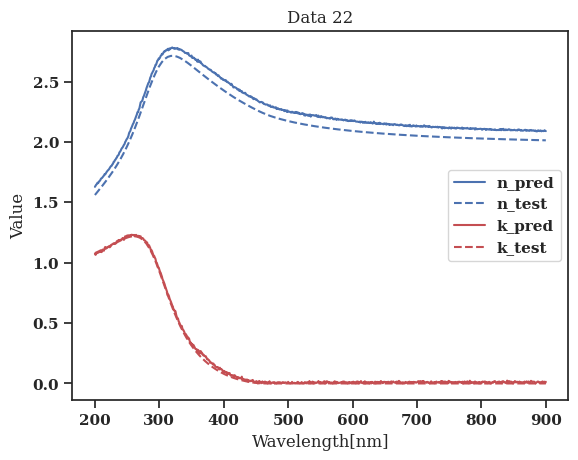

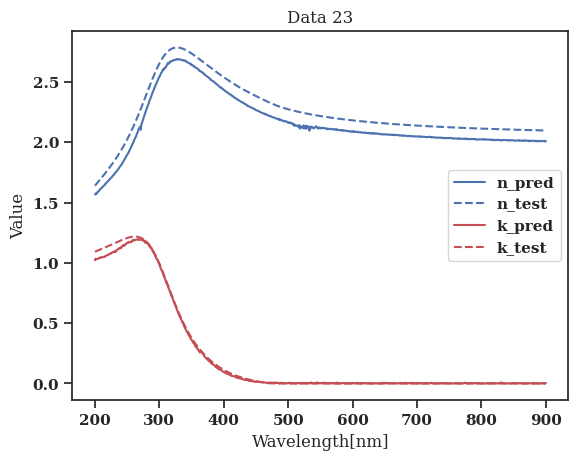

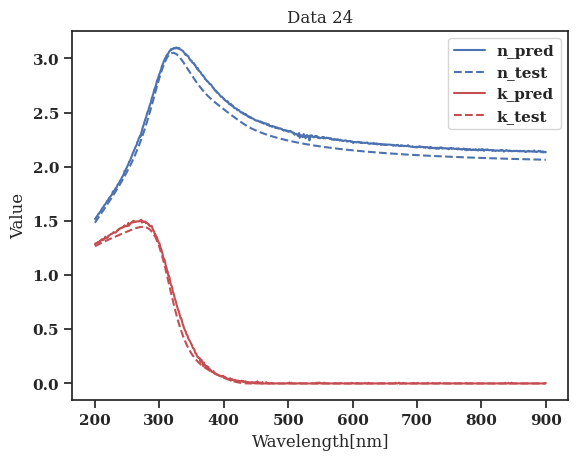

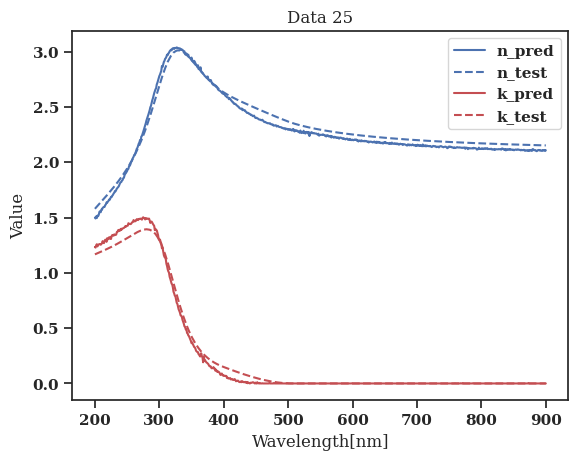

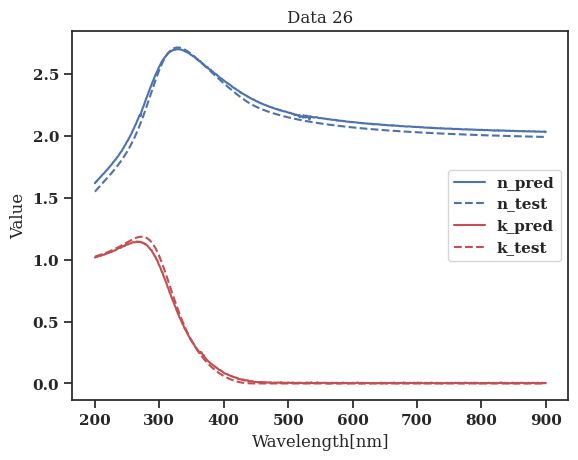

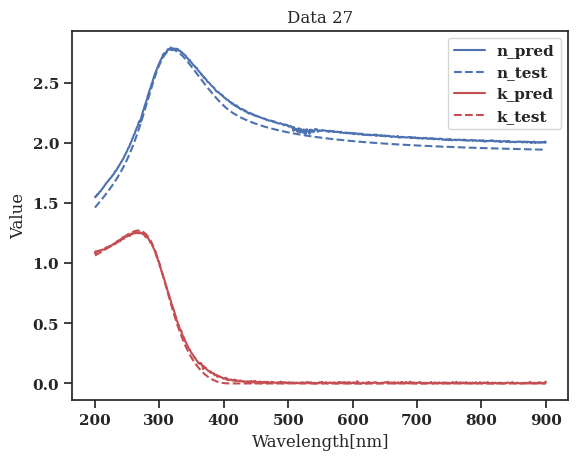

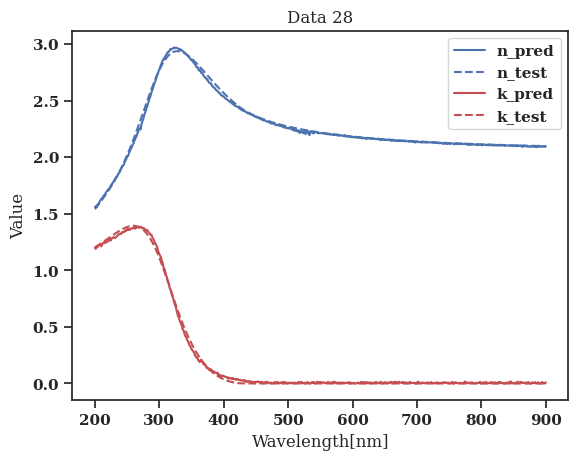

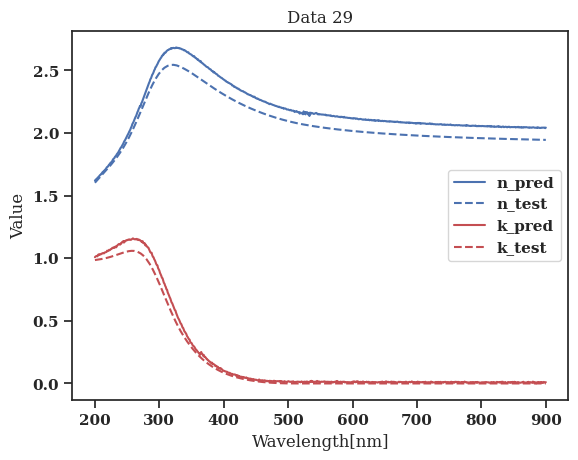

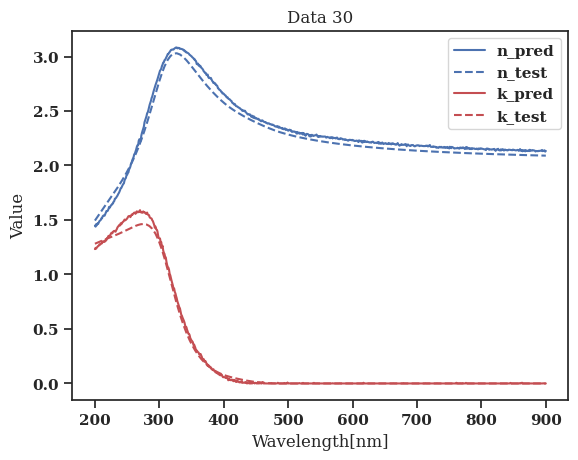

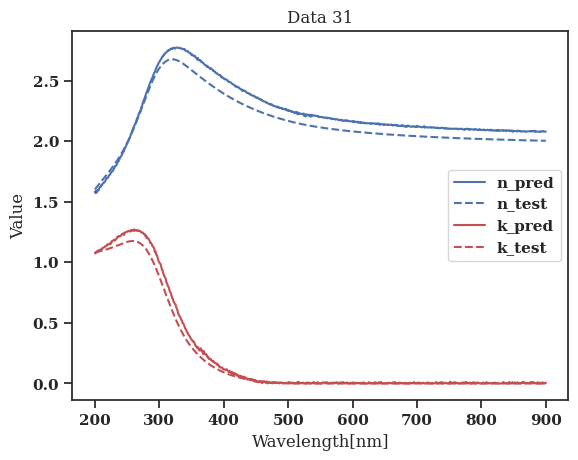

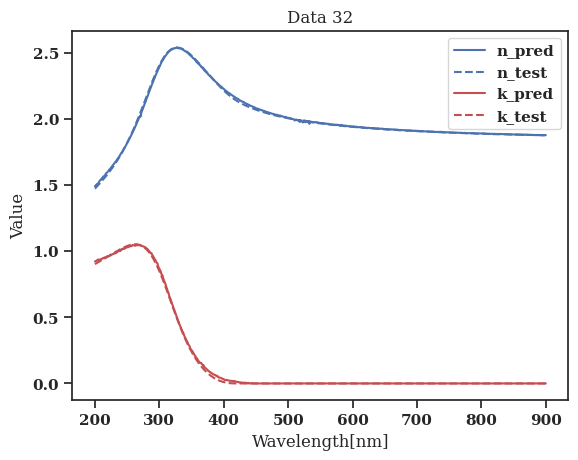

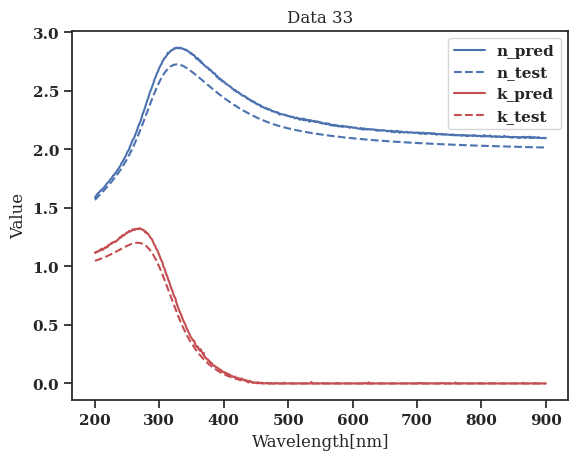

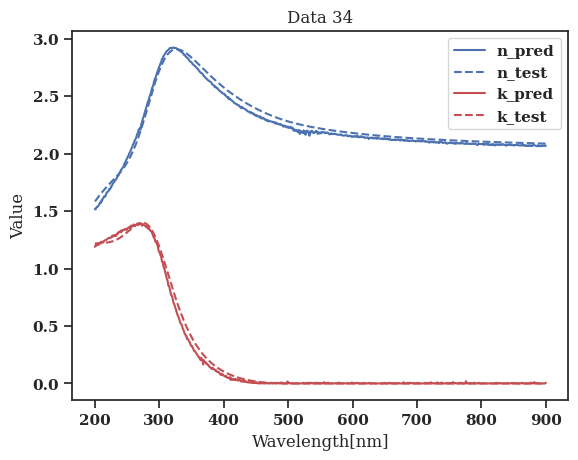

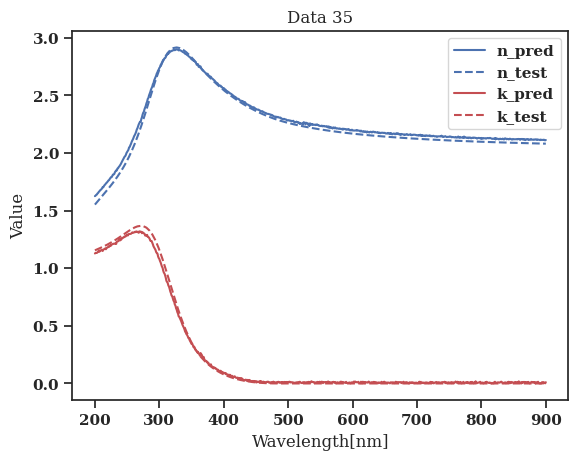

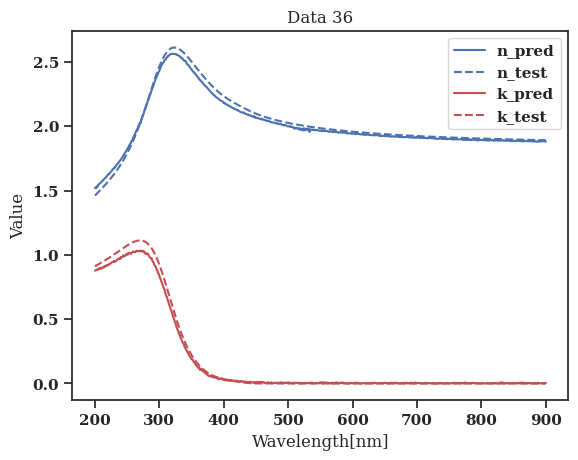

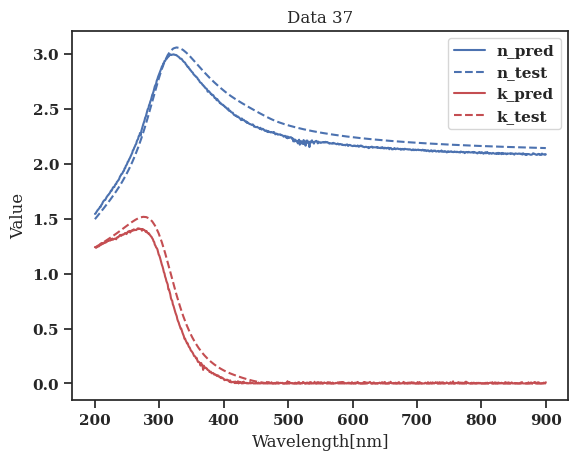

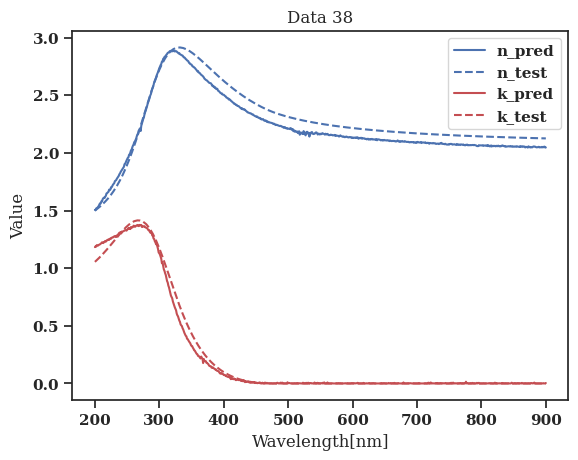

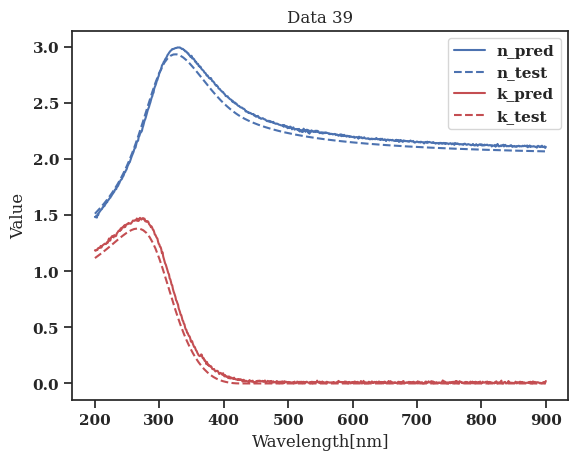

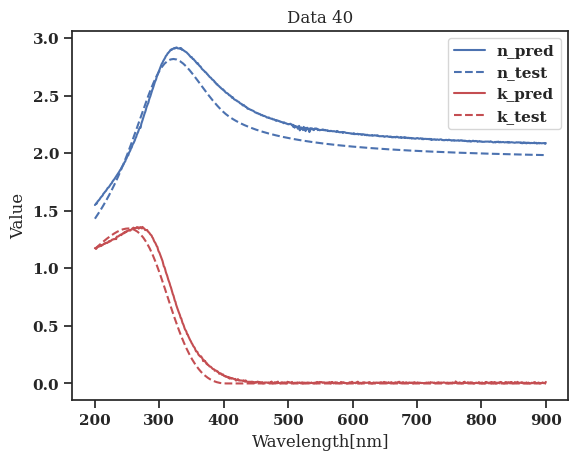

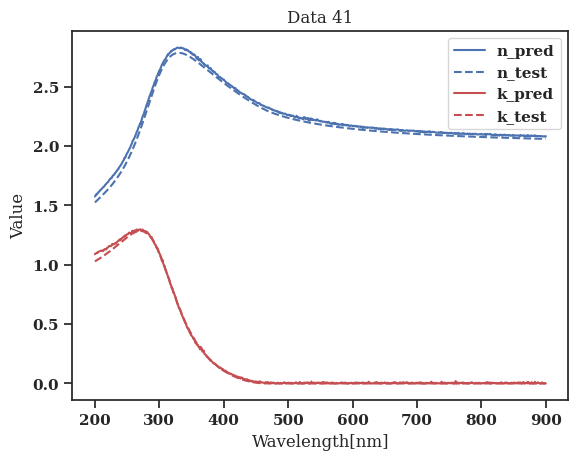

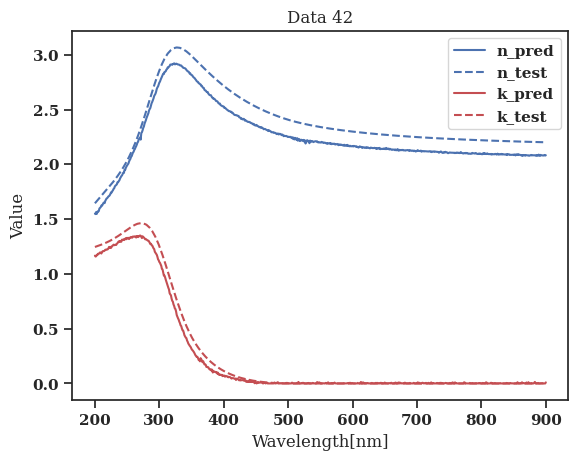

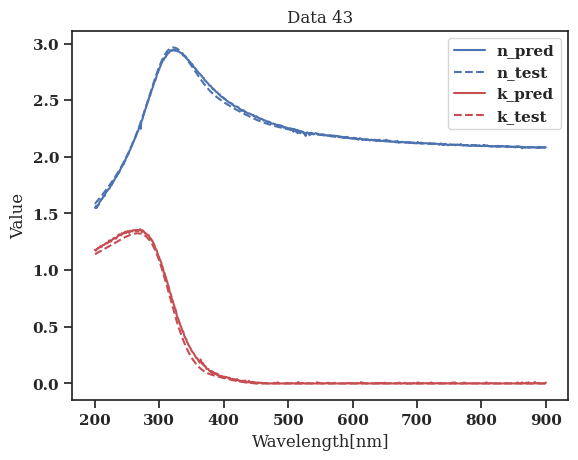

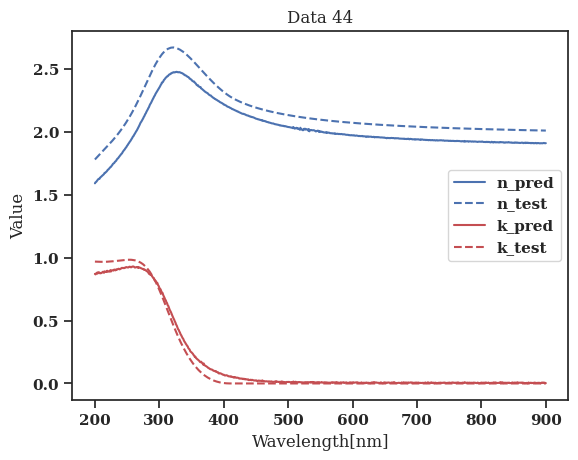

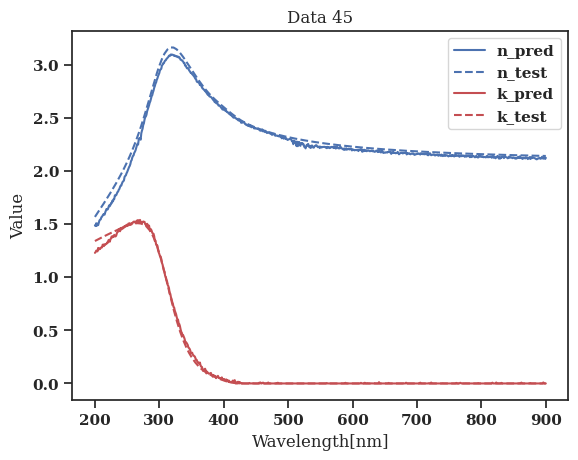

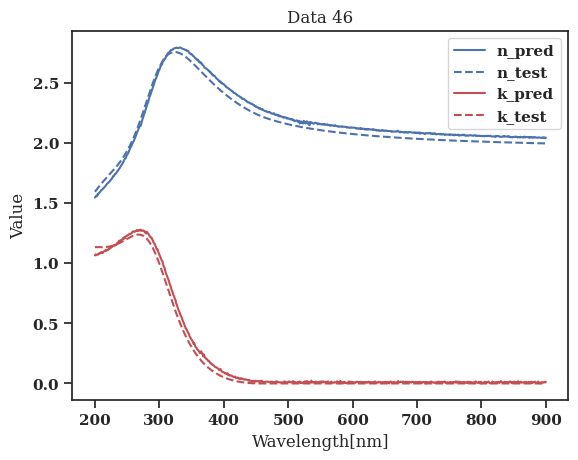

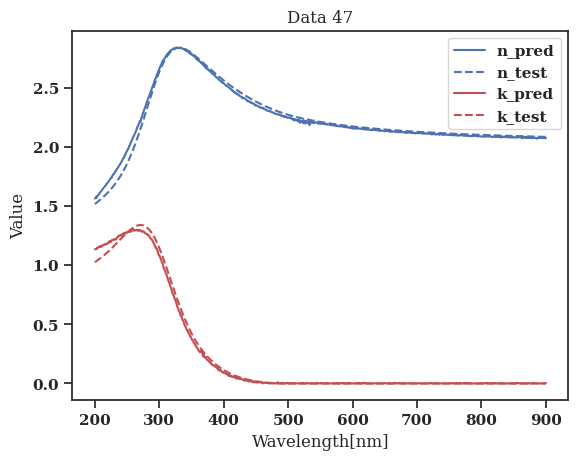

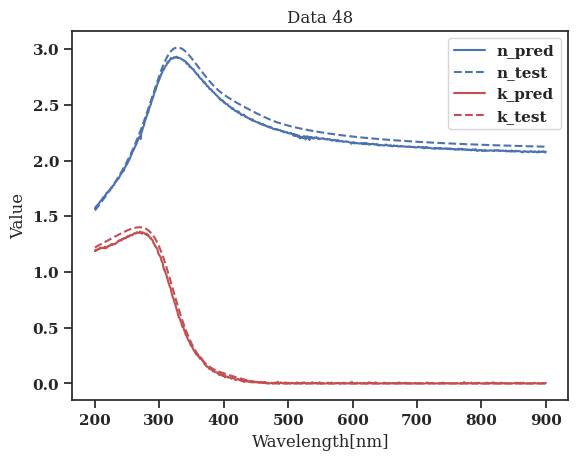

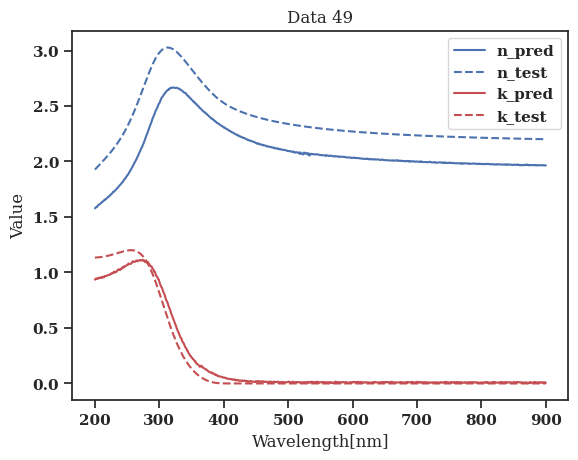

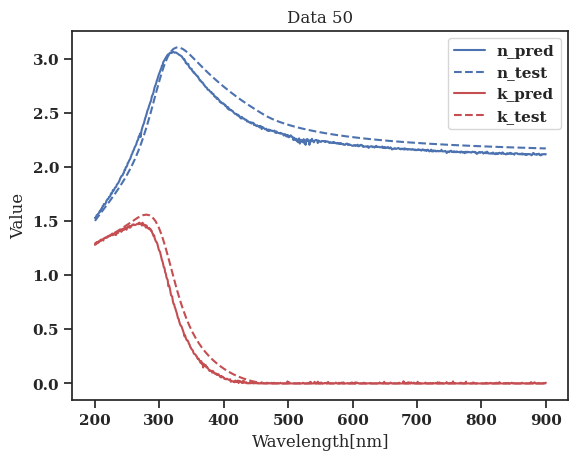

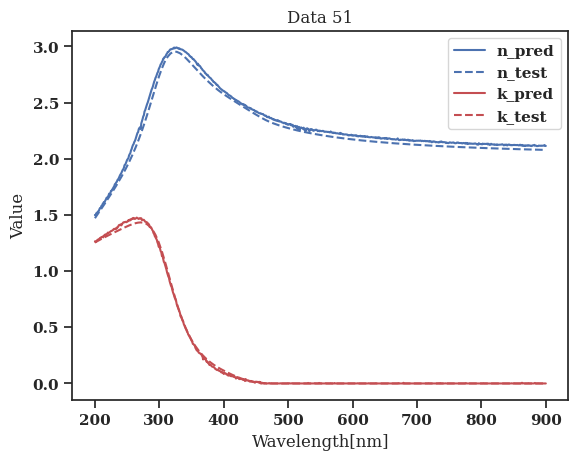

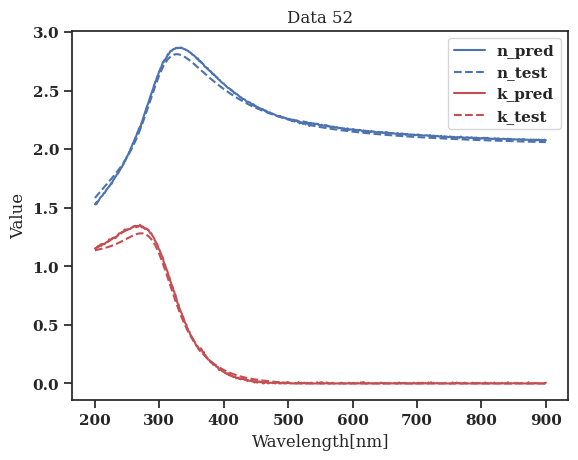

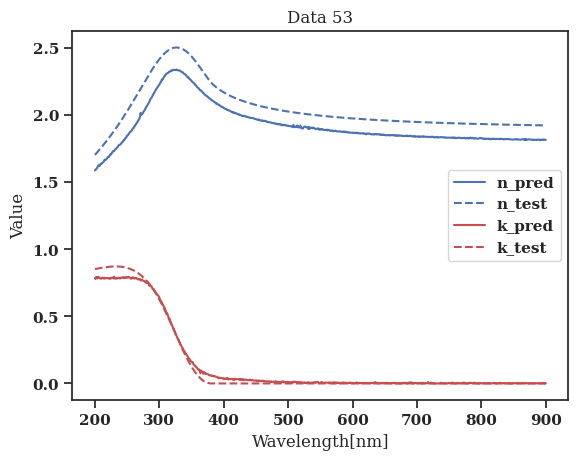

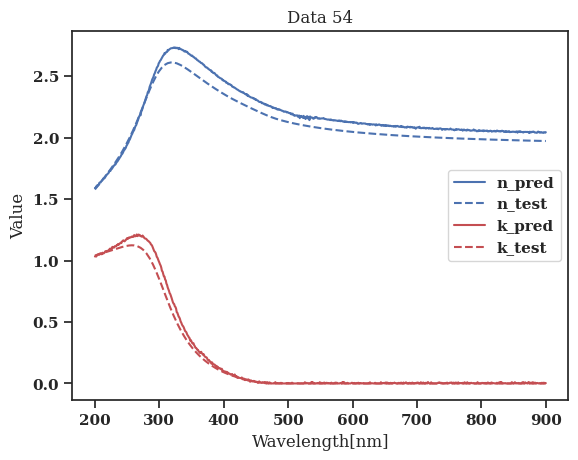

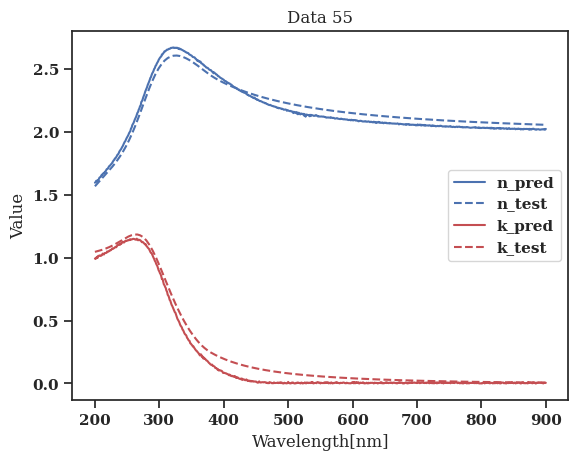

IndexError: index 55 is out of bounds for axis 0 with size 55

<Figure size 640x480 with 0 Axes>

In [19]:
# Generate X-axis data
wavelength = range(200, 901)

# Go through 55 data and draw four curves
for i in range(55):
    plt.figure()
    plt.plot(wavelength, n_pred[i], 'b-', label='n_pred')
    plt.plot(wavelength, n_test[i], 'b--', label='n_test')
    plt.plot(wavelength, k_pred[i], 'r-', label='k_pred')
    plt.plot(wavelength, k_test[i], 'r--', label='k_test')
    
    plt.xlabel('Wavelength[nm]')
    plt.ylabel('Value')
    plt.title('Data {}'.format(i+1))
    plt.legend()
    plt.show()

In [11]:
# samples_per_slice = 701
# n_samples = y_pred_reshaped.shape[0] // samples_per_slice
# feature_slices_pred = y_pred_reshaped[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
# y_pred = np.stack(feature_slices_pred, axis=0)
# print(y_pred.shape) 

# samples_per_slice = 701
# n_samples = y_test_reshaped.shape[0] // samples_per_slice
# feature_slices_test = y_test_reshaped[:n_samples * samples_per_slice].reshape((n_samples, samples_per_slice, 2))
# y_test = np.stack(feature_slices_test, axis=0)
# print(y_test.shape)

(55, 701, 2)
(55, 701, 2)


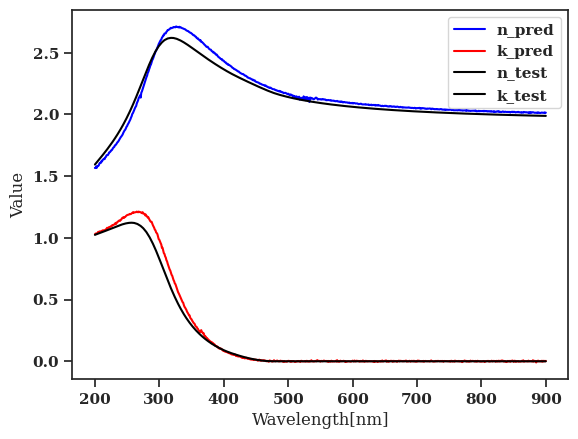

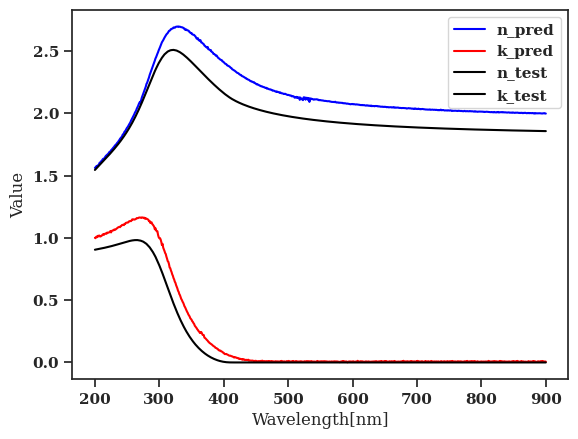

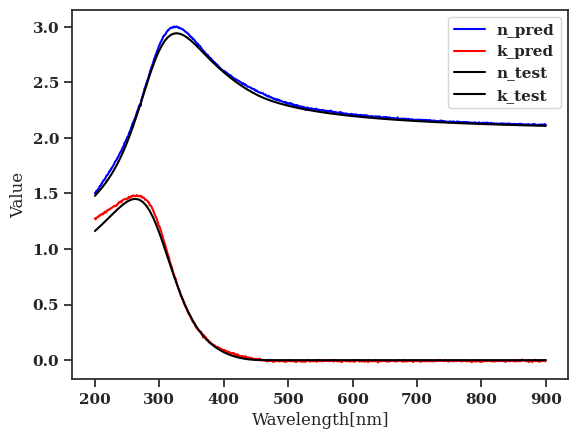

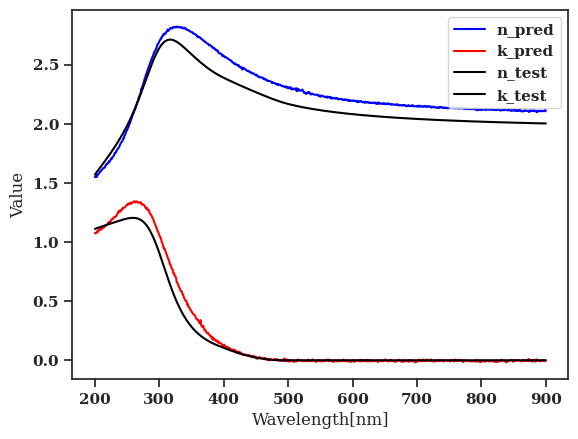

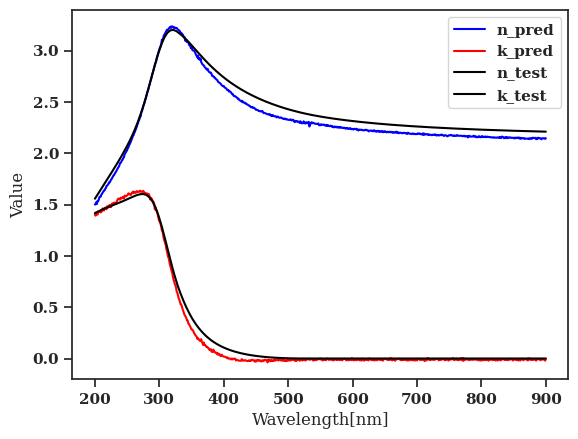

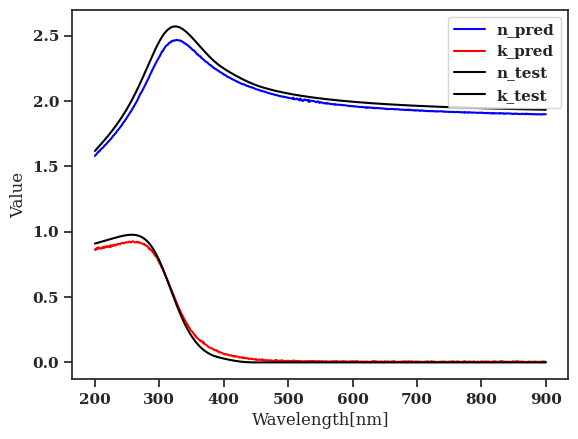

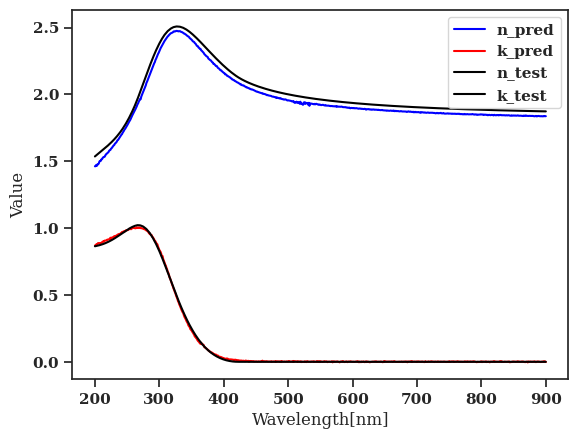

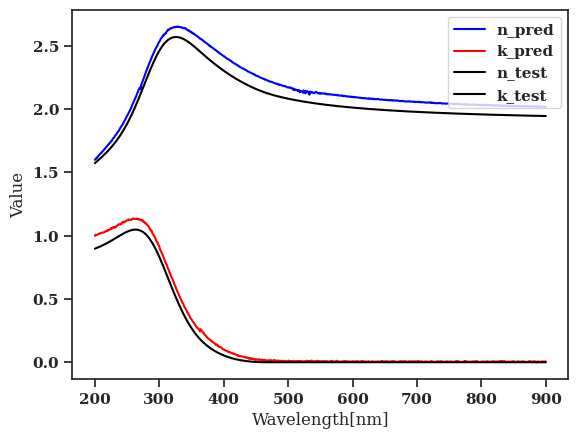

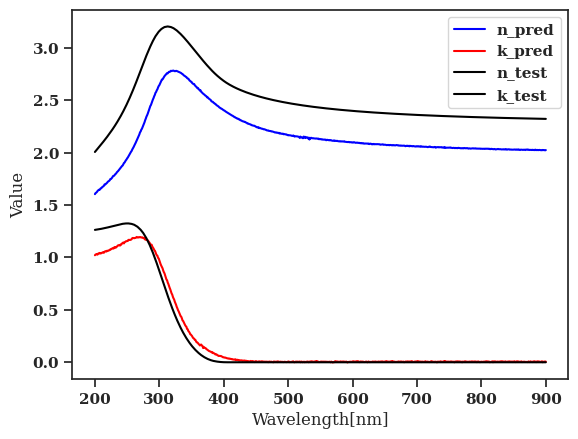

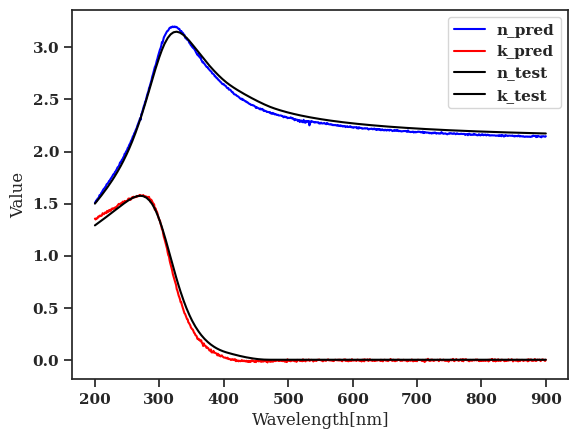

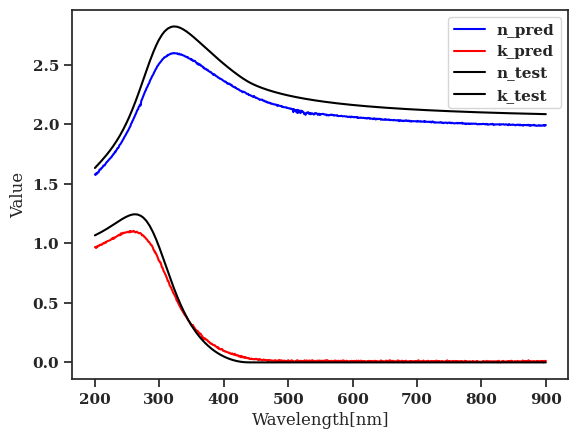

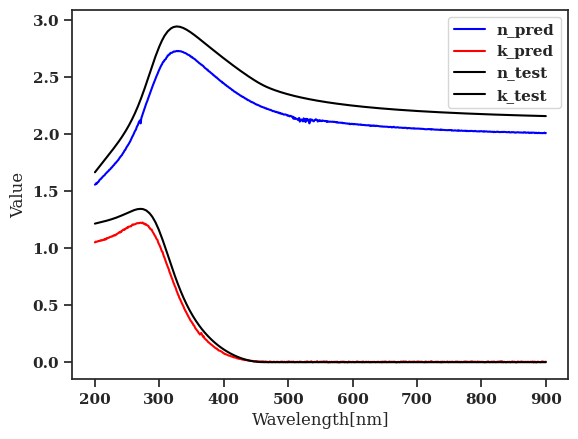

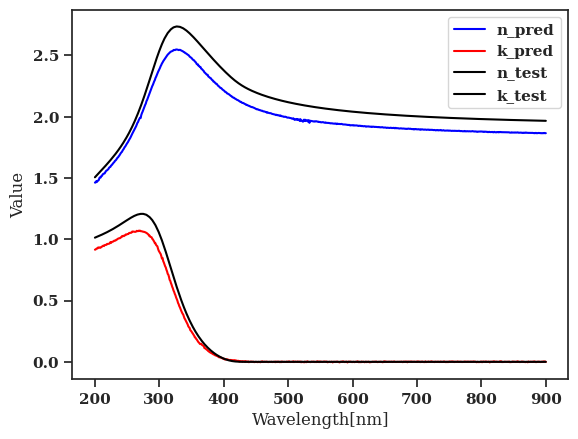

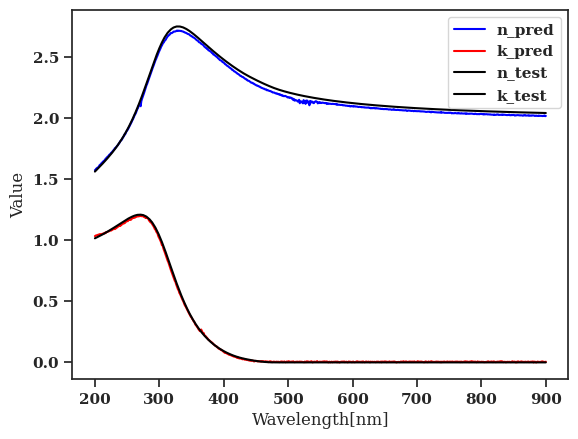

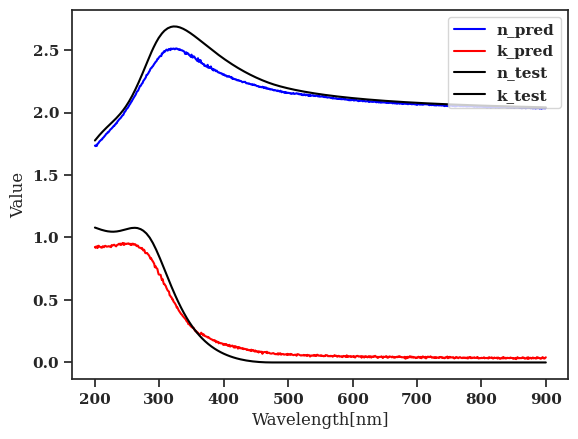

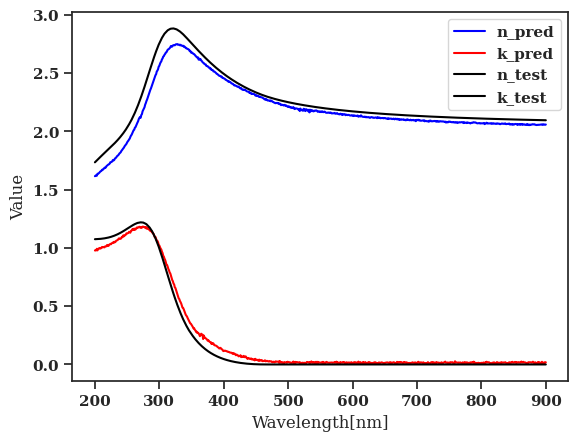

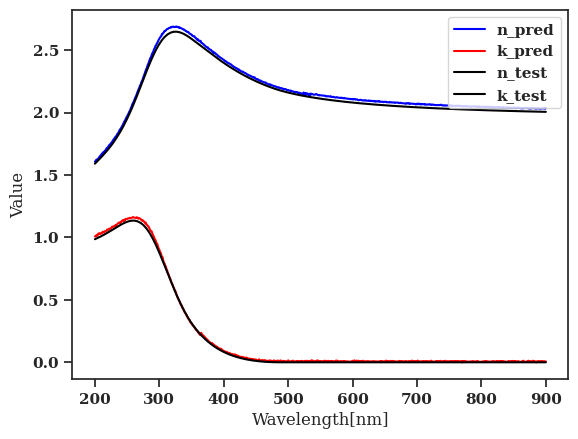

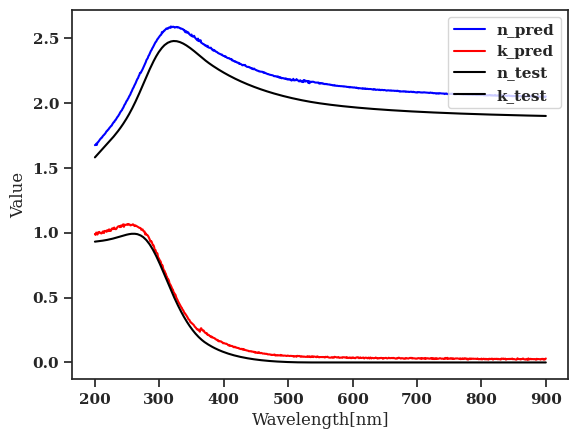

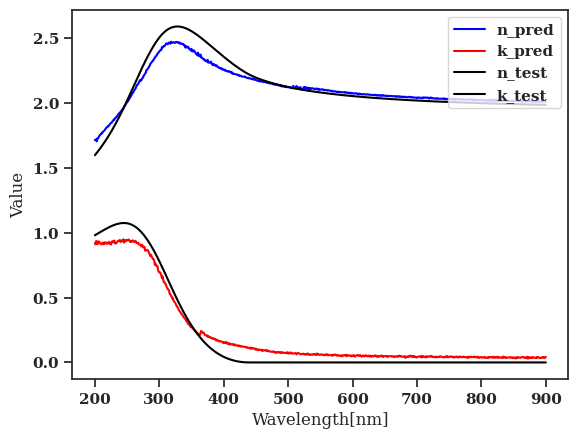

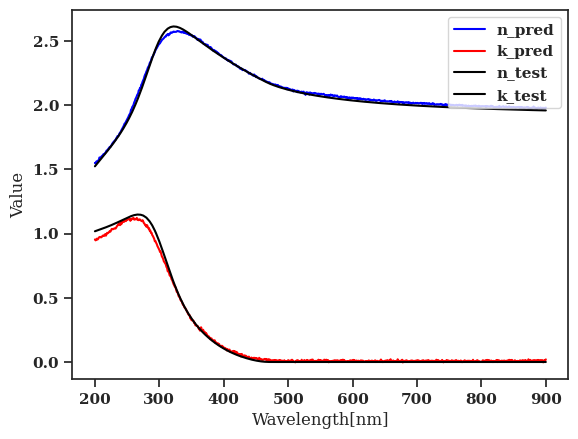

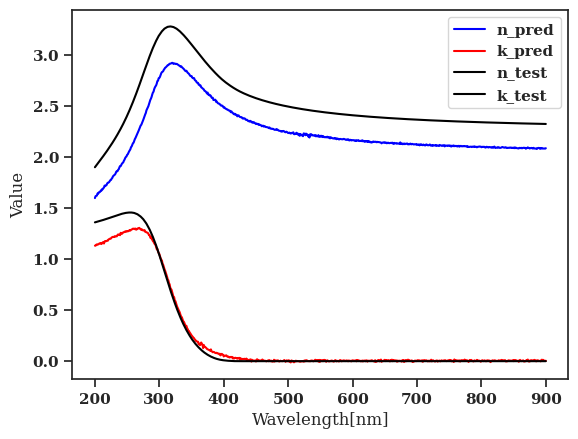

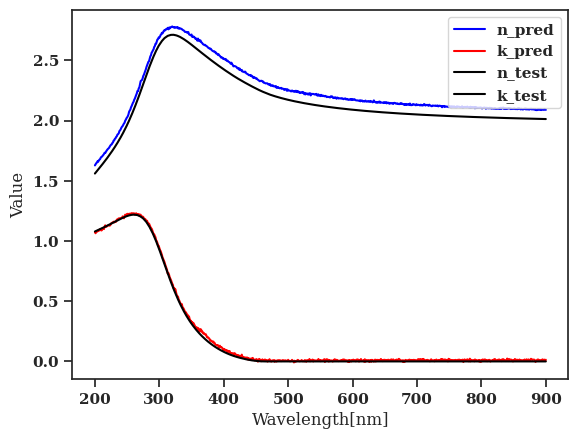

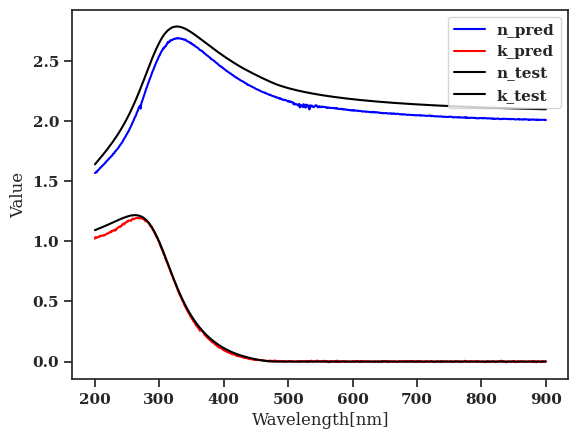

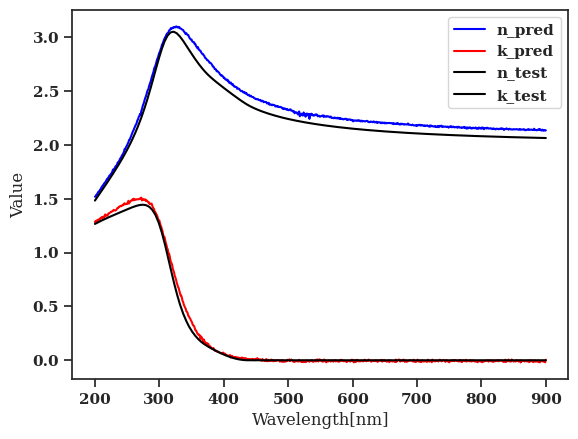

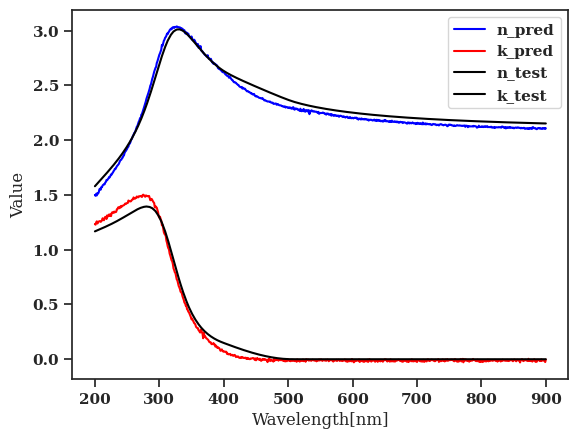

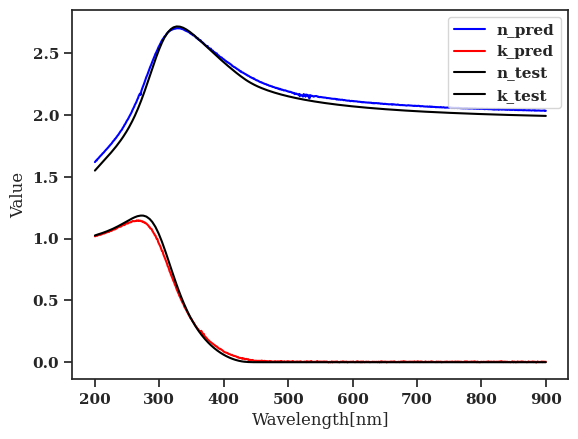

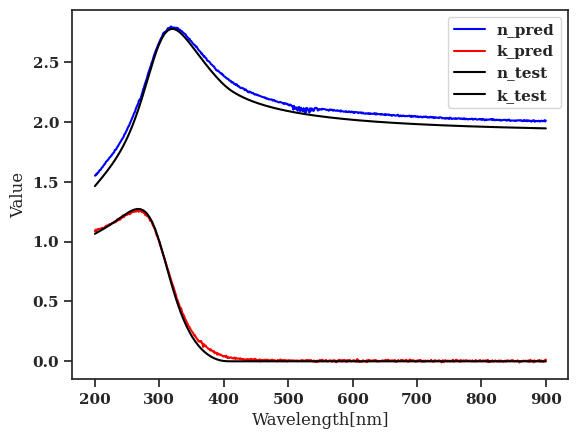

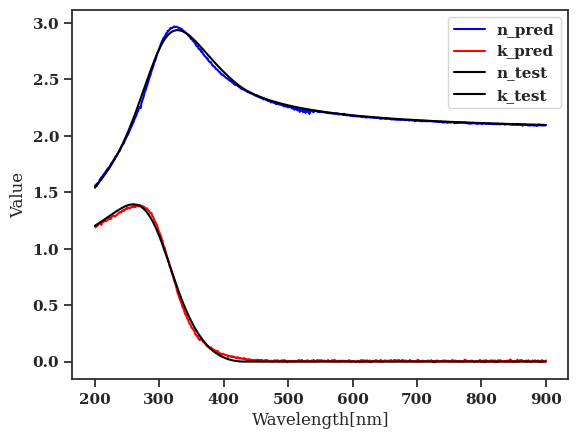

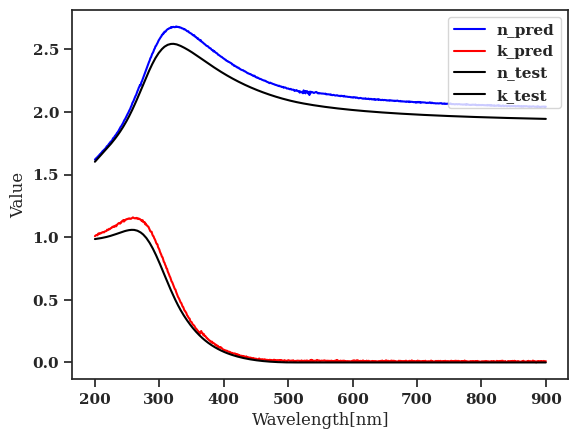

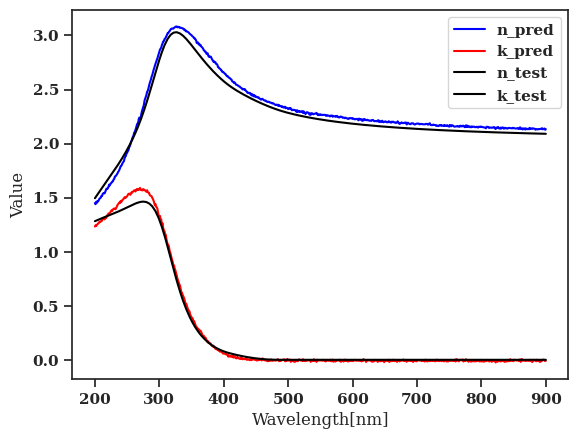

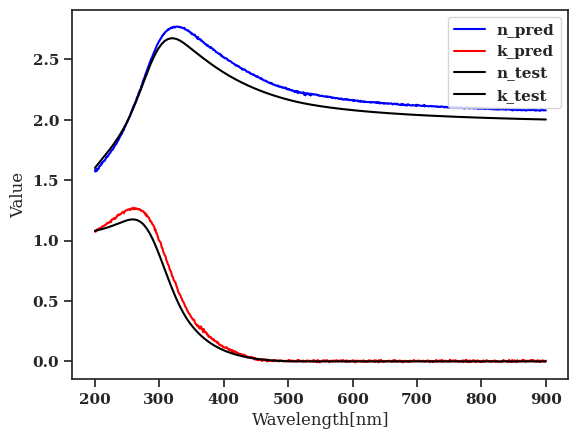

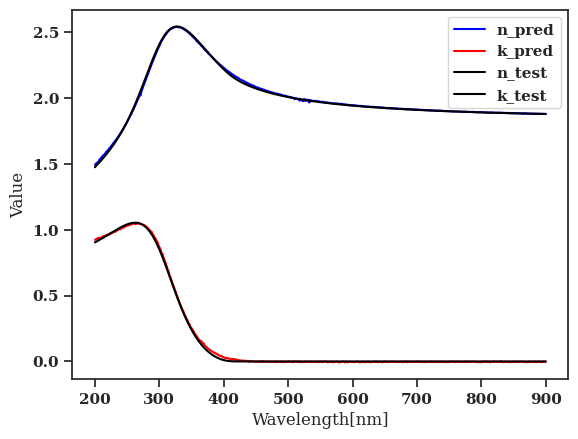

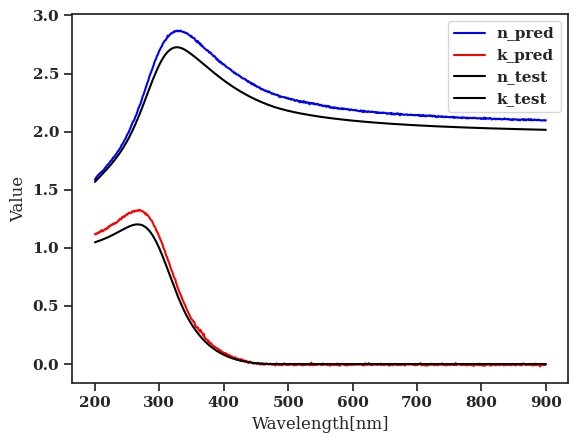

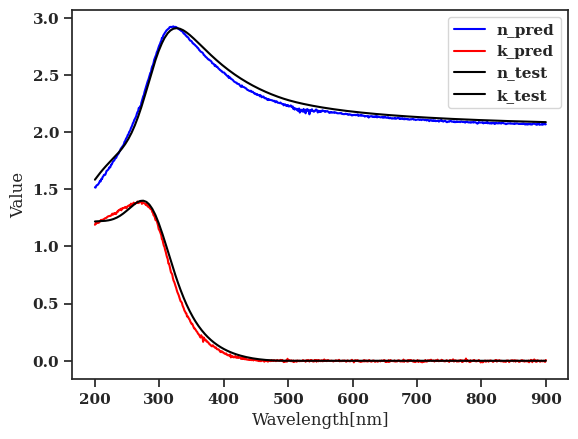

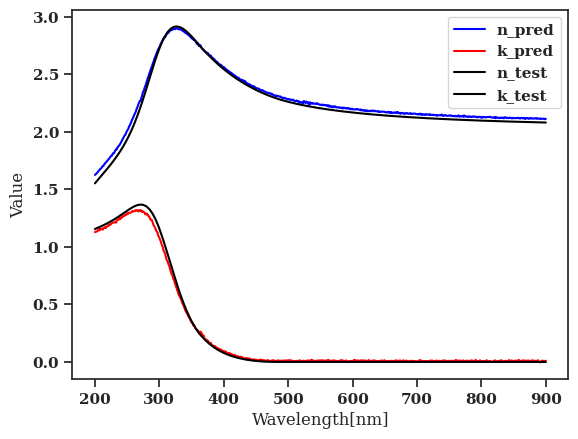

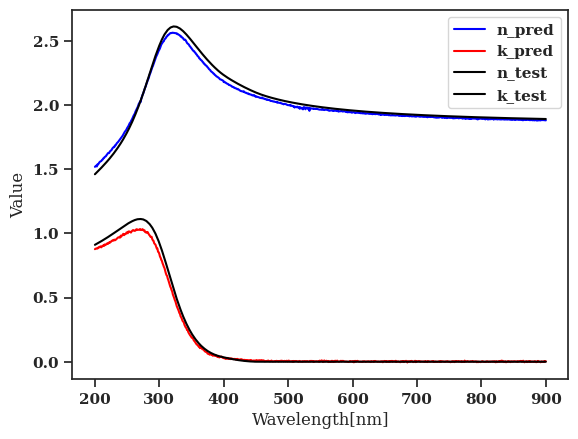

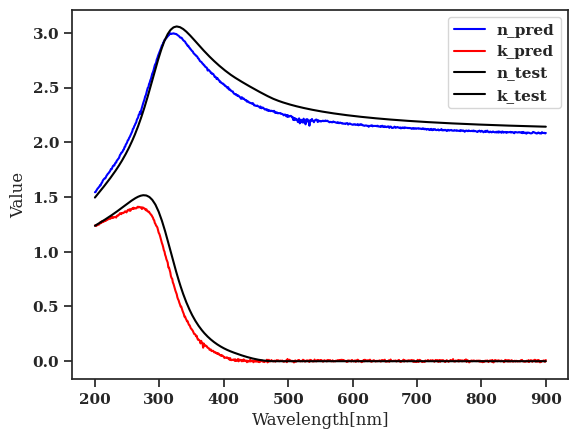

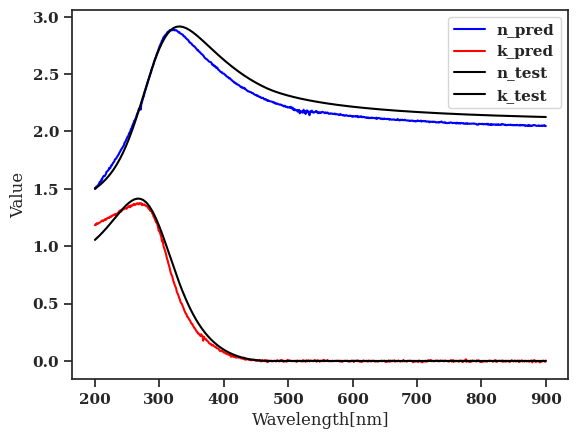

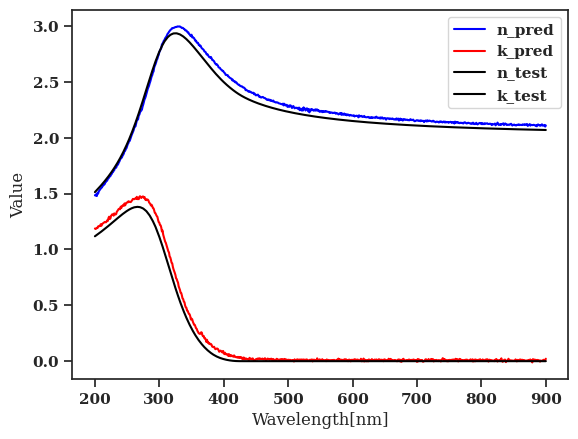

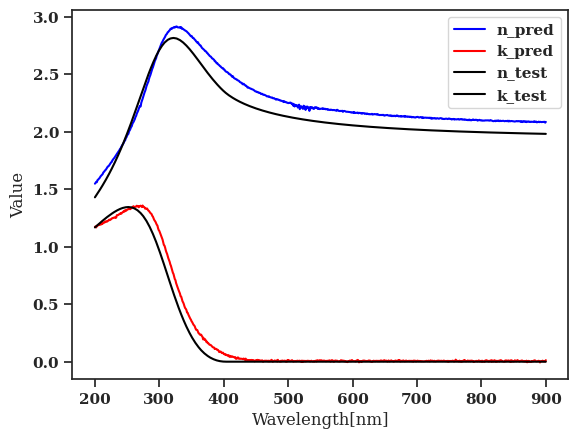

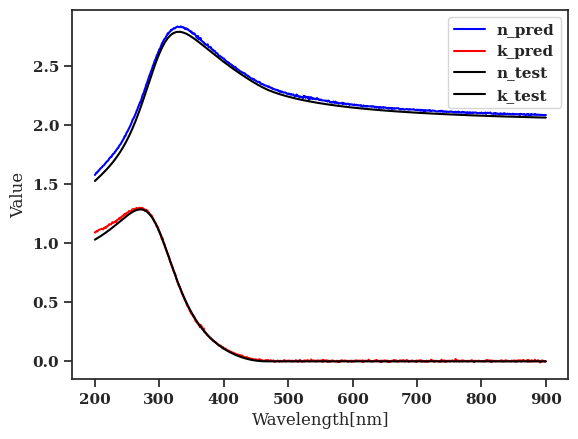

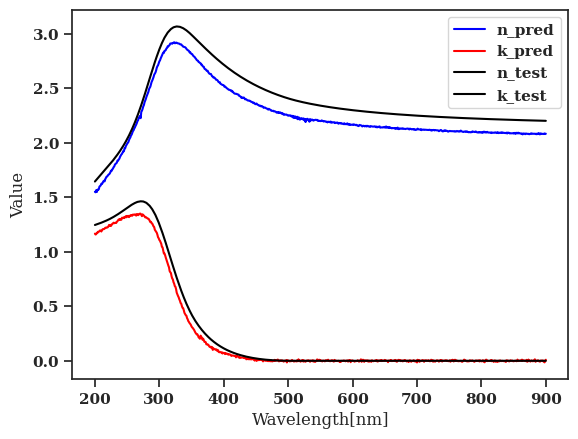

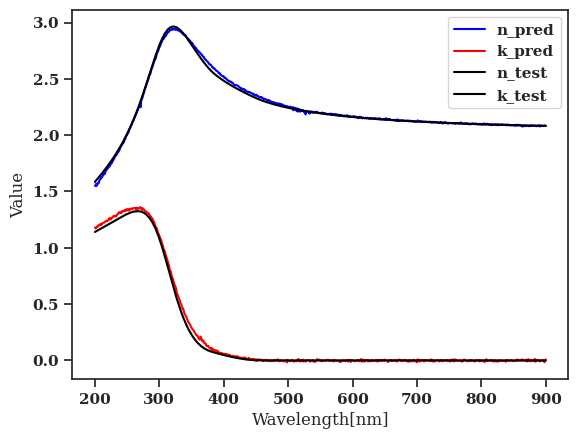

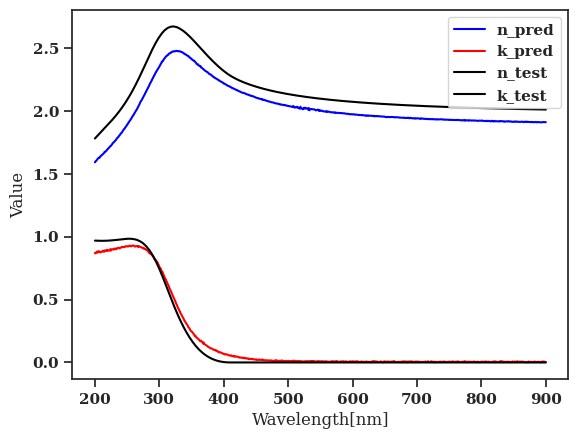

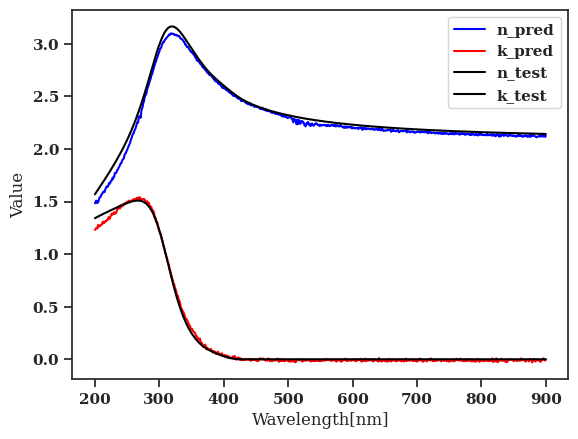

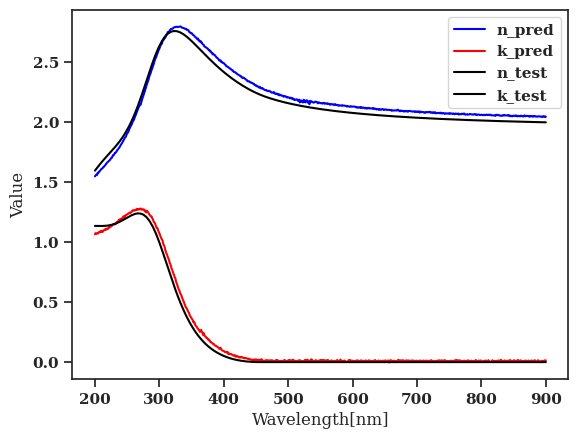

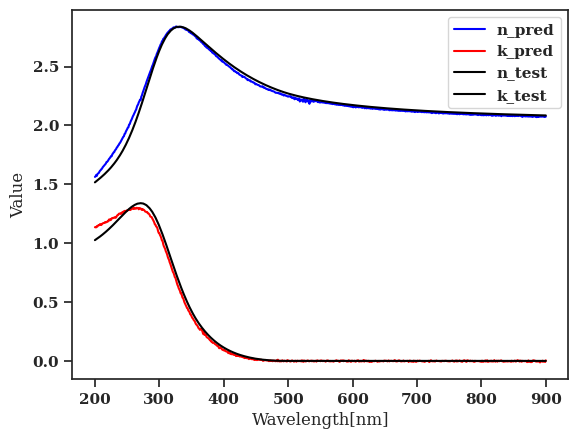

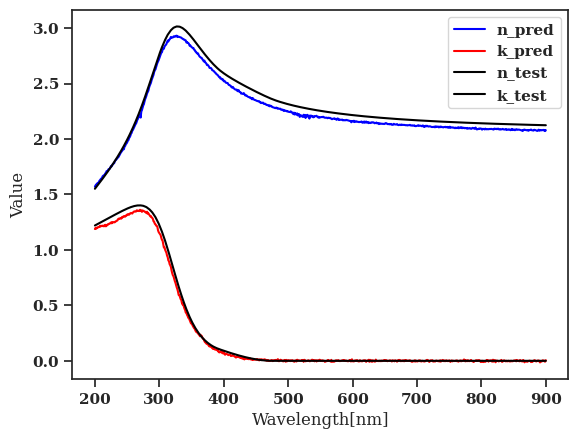

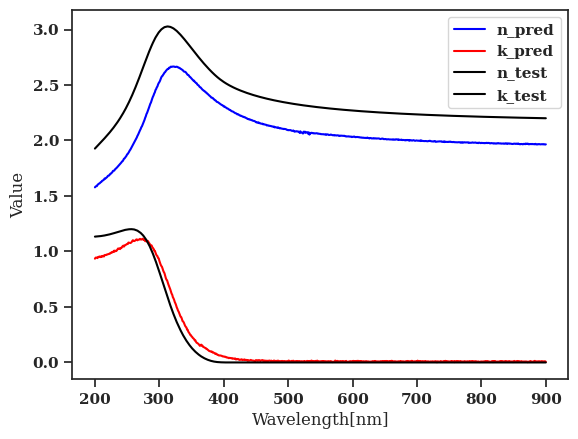

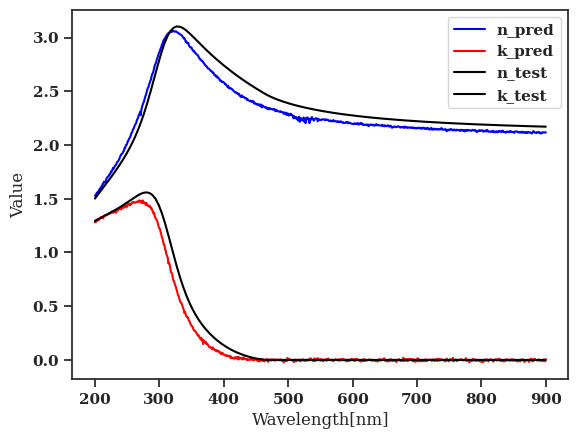

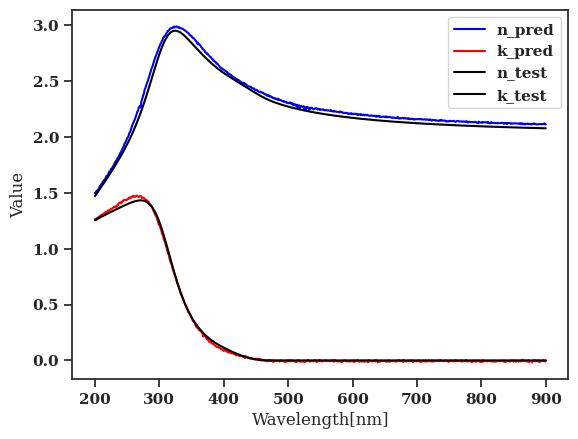

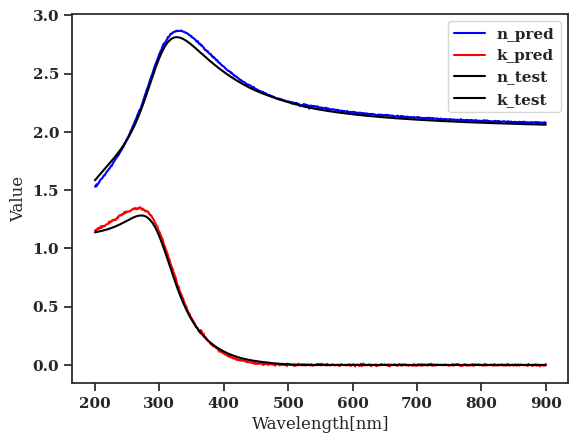

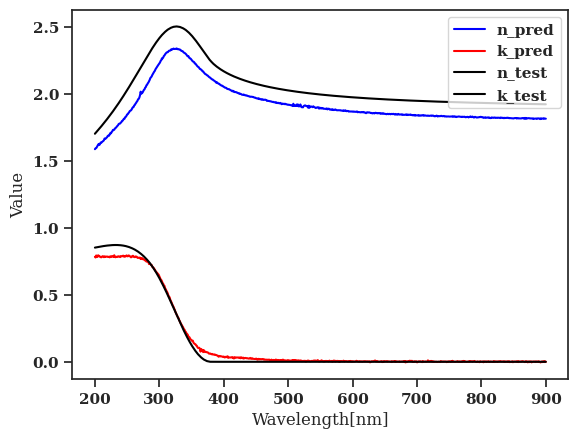

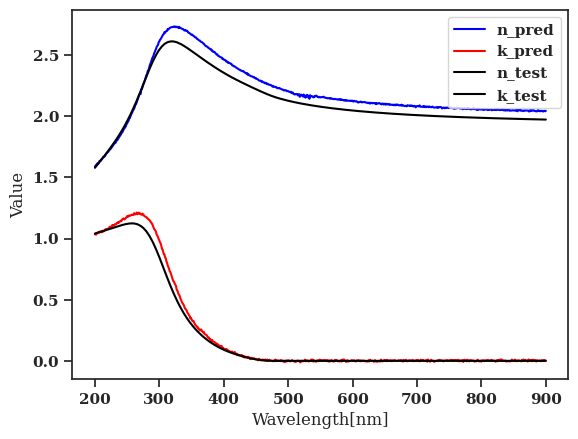

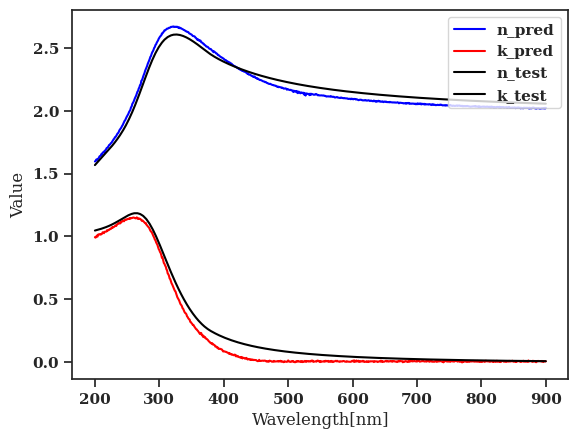

In [12]:
# for sample_index in range(y_pred.shape[0]):
#     y_pred_sample = y_pred[sample_index]
#     y_test_sample = y_test[sample_index]

#     x = range(200, 200 + y_pred_sample.shape[0])  # 修改 x 轴的值，从200开始计数

#     plt.plot(x, y_pred_sample[:, 0], label='n_pred', color='blue')
#     plt.plot(x, y_pred_sample[:, 1], label='k_pred', color='red')
#     plt.plot(x, y_test_sample[:, 0], label='n_test', color='black')
#     plt.plot(x, y_test_sample[:, 1], label='k_test', color='black')
#     plt.xlabel('Wavelength[nm]')
#     plt.ylabel('Value')
#     plt.legend(loc='upper right')
#     plt.show()

In [13]:
# y_pred_2 = np.reshape(y_pred, (-1, 2))
# y_test_2 = np.reshape(y_test, (-1, 2))
# mse = mean_squared_error(y_test_2, y_pred_2)
# print("Test MSE: ", mse)
# rmse = np.sqrt(mse)
# print("Test RMSE: ", rmse)
# mae = mean_absolute_error(y_test_2, y_pred_2)
# print("Test MAE: ", mae)
# r2 = r2_score(y_test_2, y_pred_2)
# print("Test R2 score: ", r2)

Test MSE:  0.006570376745774813
Test RMSE:  0.08105786048110826
Test MAE:  0.05115479631152145
Test R2 score:  0.9244376367738893


In [10]:
# import joblib
# # joblib.dump(model, 'jjnk_NbTi_model.joblib')

In [11]:
# model = joblib.load('jjnk_NbTi_model.joblib')